<a href="https://colab.research.google.com/github/hosamfa3096/repositorio_IA3/blob/main/Practica_DL1_T3_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

In [2]:
data_tr = pd.read_csv('./train.csv')
data_ts = pd.read_csv('./test.csv')

# Statistics numerical
data_tr.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,711.000000,573.000000,711.000000,711.000000,711.000000
mean,448.981716,28.845986,0.542897,0.393812,31.973669
std,257.156506,14.282324,1.112314,0.821998,50.468437
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.000000,19.000000,0.000000,0.000000,7.925000
50%,458.000000,28.000000,0.000000,0.000000,14.458300
75%,675.500000,36.500000,1.000000,0.000000,30.847900
max,891.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
# Statistics categorical
data_tr.select_dtypes(include='object').describe()

,Survived,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,711,711,711,711,711,158,711
unique,2,3,711,2,568,122,3
top,No,Lower,"Minahan, Miss. Daisy E",male,347082,G6,Southampton
freq,438,391,1,464,6,4,518


In [4]:
# Preprocessing
data_tr['Survived'] = data_tr['Survived'].map({'No': 0, 'Yes': 1})
data_ts['Survived'] = data_ts['Survived'].map({'No': 0, 'Yes': 1})
data_tr['Sex'] = data_tr['Sex'].map({'female': 0, 'male': 1})
data_ts['Sex'] = data_ts['Sex'].map({'female': 0, 'male': 1})
data_tr['Pclass'] = data_tr['Pclass'].map({'Lower': 3, 'Middle': 2, 'Upper': 1})
data_ts['Pclass'] = data_ts['Pclass'].map({'Lower': 3, 'Middle': 2, 'Upper': 1})

# Missing values
print('Missing in training data:\n', data_tr.isnull().sum())
print('Missing in test data: \n', data_ts.isnull().sum())

Missing in training data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            138
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         0
dtype: int64
Missing in test data: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             39
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          134
Embarked         0
dtype: int64


In [5]:
# Impute Age
data_tr['Age'] = data_tr['Age'].fillna(data_tr['Age'].median())
data_ts['Age'] = data_ts['Age'].fillna(data_tr['Age'].median())

# medians = data_tr.groupby(['Pclass', 'Sex'])['Age'].median()
# medians = medians.reset_index()
# age_norm_tr, age_norm_ts = [], []
# for c, s in medians[['Pclass', 'Sex']].values.tolist():
#     median = medians[(medians['Pclass'] == c) & (medians['Sex'] == s)]['Age'].values[0]
#     idx = (data_tr['Pclass'] == c) & (data_tr['Sex'] == s)
#     age_norm_tr.append(data_tr.loc[idx]['Age'].fillna(median))
#     age_norm_ts.append(data_ts.loc[idx]['Age'].fillna(median))

# data_tr['Age'] = pd.concat(age_norm_tr).sort_index()
# data_ts['Age'] = pd.concat(age_norm_ts).sort_index()

# Binning the Age and the Fare
data_tr['Age'] = pd.cut(data_tr['Age'], 5)
data_ts['Age'] = pd.cut(data_ts['Age'], bins=data_tr['Age'].dtype.categories)
data_tr['Fare'] = pd.qcut(data_tr['Fare'], 5)
data_ts['Fare'] = pd.cut(data_ts['Fare'], bins=data_tr['Fare'].dtype.categories)

# Convert cabin to categorical
data_tr['Deck'] = data_tr['Cabin'].str[0]
data_tr['Deck'] = data_tr['Deck'].fillna('M')
data_ts['Deck'] = data_ts['Cabin'].str[0]
data_ts['Deck'] = data_ts['Deck'].fillna('M')
# print(data_tr['Deck'].value_counts())

# Group Decks
data_tr['Deck'] = data_tr['Deck'].replace(['A', 'B', 'C'], 'ABC')
data_tr['Deck'] = data_tr['Deck'].replace(['D', 'E'], 'DE')
data_tr['Deck'] = data_tr['Deck'].replace(['F', 'G'], 'FG')
data_ts['Deck'] = data_ts['Deck'].replace(['A', 'B', 'C'], 'ABC')
data_ts['Deck'] = data_ts['Deck'].replace(['D', 'E'], 'DE')
data_ts['Deck'] = data_ts['Deck'].replace(['F', 'G'], 'FG')
# print(data_tr['Deck'].value_counts())

# Create new column Title
data_tr['Title'] = data_tr['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
data_ts['Title'] = data_ts['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
idx = data_tr['Title'].value_counts() > 10
title_names = idx[idx].index.to_list()
data_tr['Title'] = data_tr['Title'].apply(lambda x: x if x in title_names else 'Other')
data_ts['Title'] = data_ts['Title'].apply(lambda x: x if x in title_names else 'Other')

# Convert to one-hot-vectors
ohv_cols_names =  ['Embarked', 'Deck', 'Title', 'Fare', 'Age']
ohv_cols = [pd.get_dummies(pd.concat([data_tr[col], data_ts[col]]), prefix=col) for col in ohv_cols_names]
    
ohv_tr = [ohv[:len(data_tr)] for ohv in ohv_cols]
ohv_ts = [ohv[len(data_tr):] for ohv in ohv_cols]

data_tr = pd.concat([data_tr] + ohv_tr, axis=1)
data_ts = pd.concat([data_ts] + ohv_ts, axis=1)

# Drop
data_tr = data_tr.drop(['Name', 'Cabin', 'Ticket', 'PassengerId'] + ohv_cols_names, axis=1)
data_ts = data_ts.drop(['Name', 'Cabin', 'Ticket', 'PassengerId'] + ohv_cols_names, axis=1)

# Normalize numerical inputs
# for col in ['SibSp', 'Parch', 'Pclass']:
#     mean = data_tr[col].mean()
#     std = data_tr[col].std()
#     data_tr[col] = (data_tr[col] - mean) / std
#     data_ts[col] = (data_ts[col] - mean) / std

for col in ['SibSp', 'Parch', 'Pclass']:
    max_ = data_tr[col].max()
    min_ = data_tr[col].min()
    data_tr[col] = (data_tr[col] - min_) / (max_ - min_)
    data_ts[col] = (data_ts[col] - min_) / (max_ - min_)

# Get inputs/outputs
x_tr = data_tr.drop(['Survived'], axis=1).values
x_ts = data_ts.drop(['Survived'], axis=1).values

y_tr = data_tr['Survived'].values
y_ts = data_ts['Survived'].values


In [6]:
n_epochs = 500
batch_size = 128
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dropout(0.2, input_shape=(x_tr.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])
hist = model.fit(x_tr, 
                 y_tr, 
                 shuffle=True,
                 batch_size = batch_size, 
                 epochs=n_epochs, 
                 validation_split=.2)

Epoch 1/500
5/5 [==============================] - 1s 77ms/step - loss: 0.6848 - auc: 0.5295 - val_loss: 0.6643 - val_auc: 0.5901
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6800 - auc: 0.5450 - val_loss: 0.6571 - val_auc: 0.6206
Epoch 3/500
5/5 [==============================] - 0s 8ms/step - loss: 0.6626 - auc: 0.6134 - val_loss: 0.6500 - val_auc: 0.6373
Epoch 4/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6698 - auc: 0.5704 - val_loss: 0.6431 - val_auc: 0.6730
Epoch 5/500
5/5 [==============================] - 0s 8ms/step - loss: 0.6649 - auc: 0.5887 - val_loss: 0.6357 - val_auc: 0.7077
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6548 - auc: 0.6361 - val_loss: 0.6292 - val_auc: 0.7396
Epoch 7/500
5/5 [==============================] - 0s 9ms/step - loss: 0.6606 - auc: 0.5947 - val_loss: 0.6228 - val_auc: 0.7574
Epoch 8/500
5/5 [==============================] - 0s 8ms/step - loss: 0.6465 - auc: 0.6582 - v

In [7]:
y_tr.shape

(711,)

2/2 [==============================] - 0s 4ms/step - loss: 0.4191 - auc: 0.8854
Error (Test): 0.4191268980503082
AUC (Test): 0.885375440120697


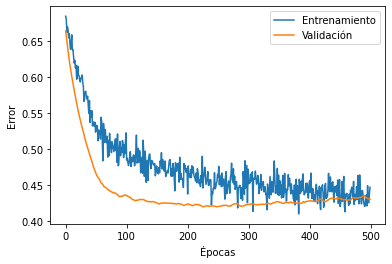

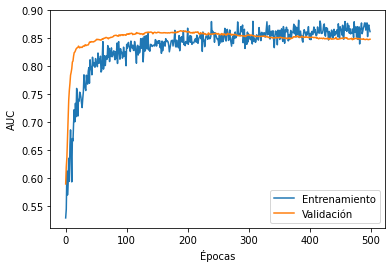

In [8]:
def plot_curves(history):
  plt.figure()
  plt.xlabel('Épocas')
  plt.ylabel('Error')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['Entrenamiento', 'Validación'])

  plt.figure()
  plt.xlabel('Épocas')
  plt.ylabel('AUC')
  plt.plot(history['auc'])
  plt.plot(history['val_auc'])
  plt.legend(['Entrenamiento', 'Validación'], loc='lower right');

plot_curves(hist.history)
results = model.evaluate(x_ts, y_ts, batch_size=batch_size)
print(f"Error (Test): {results[0]}\nAUC (Test): {results[1]}")

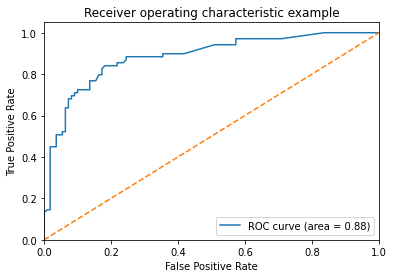

In [ ]:
probabilities = model.predict(x_ts).reshape(len(x_ts))

fpr, tpr, _ = roc_curve(y_ts, probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
predictions = np.where(probabilities > .5, 1, 0)
confusion_matrix(y_true=y_ts, y_pred=predictions)

array([[95, 15],
       [19, 50]])